# Generate cerebra_data
Notebook to generate cerebra_data folder (cerebra_atlas_python/cerebra_data)

**Requirements:**
- FreeSurfer (https://surfer.nmr.mgh.harvard.edu/)
- Datasets:
    - [CerebrA](https://gin.g-node.org/anamanera/CerebrA/src/master/): $CEREBRA_DIR
    - [ICBM 2009c Nonlinear Symmetric [NIFTI]](https://nist.mni.mcgill.ca/icbm-152-nonlinear-atlases-2009/): $ICBM_DIR
- Install requirements.txt

In [1]:
# Notebook setup
%load_ext autoreload
%autoreload 2
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
# Imports
import os
import os.path as op
import logging
import mne
import numpy as np
from mne import bem
from cerebra_atlas_python.mni_average import MNIAverage
from cerebra_atlas_python.utils import inspect_img,setup_logging

In [4]:
## Constants

# Datasets
ICBM_DIR = op.join(os.getenv("DATASETS_DIR"),"ICBM_2009c_Nonlinear_Symmetric/mni_icbm152_nlin_sym_09c_nifti")
CEREBRA_DIR = op.join(os.getenv("DATASETS_DIR"),"Cerebra")

# FreeSurfer
FS_SUBJECTS_DIR = os.getenv("SUBJECTS_DIR")
NEW_SUBJECT_NAME = "icbm152" # Used by FreeSurfer
NEW_FS_SUBJECT_DIR = op.join(FS_SUBJECTS_DIR,NEW_SUBJECT_NAME)
BEM_DIR = op.join(NEW_FS_SUBJECT_DIR, "bem")

# Output dir
CEREBRA_DATA_DIR = "../cerebra_atlas_python/cerebra_data"
CEREBRA_DATA_FS_DIR = op.join(CEREBRA_DATA_DIR, "FreeSurfer")
CEREBRA_DATA_ICBM152_DIR = op.join(CEREBRA_DATA_FS_DIR, "subjects", NEW_SUBJECT_NAME)
CEREBRA_DATA_MNE_DIR = op.join(CEREBRA_DATA_DIR, "MNE")
# HEAD_MRI_T_PATH = op.join(CEREBRA_DATA_icbm152_DIR,"head_mri_t.fif")
# FIDUCIALS_PATH = op.join(CEREBRA_DATA_icbm152_DIR,"bem/icbm152-fiducials.fif")
CEREBRA_VOLUME_PATH = op.join(CEREBRA_DATA_DIR,"volume.npy")
CEREBRA_AFFINE_PATH = op.join(CEREBRA_DATA_DIR,"affine.npy")
# INFO_PATH = op.join(CEREBRA_DATA_DIR,"info.fif")
# MRI_RAS_T_PATH = op.join(CEREBRA_DATA_DIR,"mri_ras-trans.fif")
# MONTAGE_KIND = "GSN-HydroCel-129" TODO: DELETE
# MONTAGE_HEAD_SIZE = 0.1025 TODO: DELETE

In [5]:
setup_logging("INFO")

In [6]:
# FREESURFER must be installed
!freesurfer --version


FreeSurfer is a set of tools for the analysis and visualization
of structural and functional brain imaging data. FreeSurfer
also refers to the structural imaging stream within the
FreeSurfer suite.

Users should consult the online documentation available at:

  http://surfer.nmr.mgh.harvard.edu

Alternatively, the 'recon-all' command help-text provides
adequate information to begin processing subject data, such
as the sample subject 'bert' found in the 'freesurfer/subjects'
directory.  Type 'recon-all --help' to view this help-text.

Direct comments and questions to:

  freesurfer@nmr.mgh.harvard.edu

You are running this version of FreeSurfer:

  freesurfer-linux-ubuntu22_x86_64-7.4.1-20230614-7eb8460



# 1) Use Freesurfer to perform cortical reconstruction and generate Boundary Element Model (BEM) surfaces

#### Run fs recon-all

In [7]:
if op.exists(NEW_FS_SUBJECT_DIR):
    logging.info("%s FreeSurfer subject already exists, skipping recon-all", NEW_SUBJECT_NAME)
else:
    logging.info("Running recon-all for %s", NEW_SUBJECT_NAME)
    !recon-all -subjid $NEW_SUBJECT_NAME -i $ICBM_DIR/mni_icbm152_t1_tal_nlin_sym_09c.nii -all
!mkdir -p $CEREBRA_DATA_ICBM152_DIR/mri
!cp $NEW_FS_SUBJECT_DIR/mri/T1.mgz $CEREBRA_DATA_ICBM152_DIR/mri/T1.mgz
!cp $NEW_FS_SUBJECT_DIR/mri/wm.asegedit.mgz $CEREBRA_DATA_ICBM152_DIR/mri/wm.mgz

 [INFO] 2024-03-27 16:12:57.790 3589068124 - <module>: icbm152 FreeSurfer subject already exists, skipping recon-all


#### Run mne.bem.make_watershed_bem 
BEM surfaces were generated using the FreeSurfer watershed algorithm through MNE's `mne.bem.make_watershed_bem` and then manually edited so that all inner surfaces are contained within the outer surfaces as explained [here](https://mne.tools/stable/auto_tutorials/forward/80_fix_bem_in_blender.html).

In [9]:
NEW_FS_SUBJECT_DIR

'/home/carlos/Datasets/subjects/icbm152'

In [8]:
if op.exists(BEM_DIR):
    logging.info("BEM surfaces for subject %s already exist, skipping make_watershed_bem", NEW_SUBJECT_NAME)
else: 
    logging.info("Running make_watershed_bem for %s", NEW_SUBJECT_NAME)
    mne.bem.make_watershed_bem(NEW_SUBJECT_NAME)
!mkdir -p $CEREBRA_DATA_ICBM152_DIR/bem
!cp $NEW_FS_SUBJECT_DIR/bem/* $CEREBRA_DATA_ICBM152_DIR/bem

 [INFO] 2024-03-27 16:13:22.512 3388132949 - <module>: BEM surfaces for subject icbm152 already exist, skipping make_watershed_bem


cp: -r not specified; omitting directory '/home/carlos/Datasets/subjects/icbm152/bem/do_not_cpt'
cp: -r not specified; omitting directory '/home/carlos/Datasets/subjects/icbm152/bem/watershed'


<div style="display:flex;align-items:center;justify-content:center;background-color:black;padding:25px;flex-direction:column"><img src="../images/bem_manual_edit.png" alt="BEM MANUAL EDIT" width=50%></img><br/><small>Manual editing of BEM surfaces produced by make_watershed_bem (FreeSurfer's mri_watershed)</small></div>

# 2) Convert CerebrA volume to T1w scan coordinate frame

In [10]:
!mri_convert $CEREBRA_DIR"/CerebrA.nii" $CEREBRA_DIR"/CerebrA.mgz"
!mri_vol2vol --mov $CEREBRA_DIR"/CerebrA.mgz" --o $CEREBRA_DIR"/CerebrA_in_head.mgz" --regheader --targ $CEREBRA_DATA_ICBM152_DIR/mri/T1.mgz --interp nearest

mri_convert /home/carlos/Datasets/Cerebra/CerebrA.nii /home/carlos/Datasets/Cerebra/CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra/CerebrA.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra/CerebrA.mgz...
movvol /home/carlos/Datasets/Cerebra/CerebrA.mgz
targvol ../cerebra_atlas_python/cerebra_data/FreeSurfer/subjects/icbm152/mri/T1.mgz
outvol /home/carlos/Datasets/Cerebra/CerebrA_in_head.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  nearest (0)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1711792336

Computing registration based on scanner-to-scanner

Final tkRAS-to-tkRAS Matrix is:
-1.00000   0.00000   0.00000   0.00000;
 0.00000   0.00000   1.00000   0.00000;
 0.00000  -1.00000   0.00000   0.00000;
 0.00000   0.00000   0.00000   1.00000;


Vox2Vox Matrix is:
-1.00000   0.00000   0.00000   224.50000;
 0.00000   0.00000   1.00000  -13.50000;
 0.00000  -1

In [13]:
from cerebra_atlas_python.utils import get_volume_ras

cerebra_volume, cerebra_affine = get_volume_ras(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")
wm_volume, _ = get_volume_ras(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")

# Use wm to fill volume
cerebra_volume[(wm_volume != 0) & (cerebra_volume == 0)] = 103

np.save(CEREBRA_VOLUME_PATH,cerebra_volume)
np.save(CEREBRA_AFFINE_PATH, cerebra_affine)

##### Plot alignment

(<Figure size 1500x1500 with 4 Axes>,
 array([[<Axes: xlabel='Y', ylabel='Z'>, <Axes: xlabel='X', ylabel='Z'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

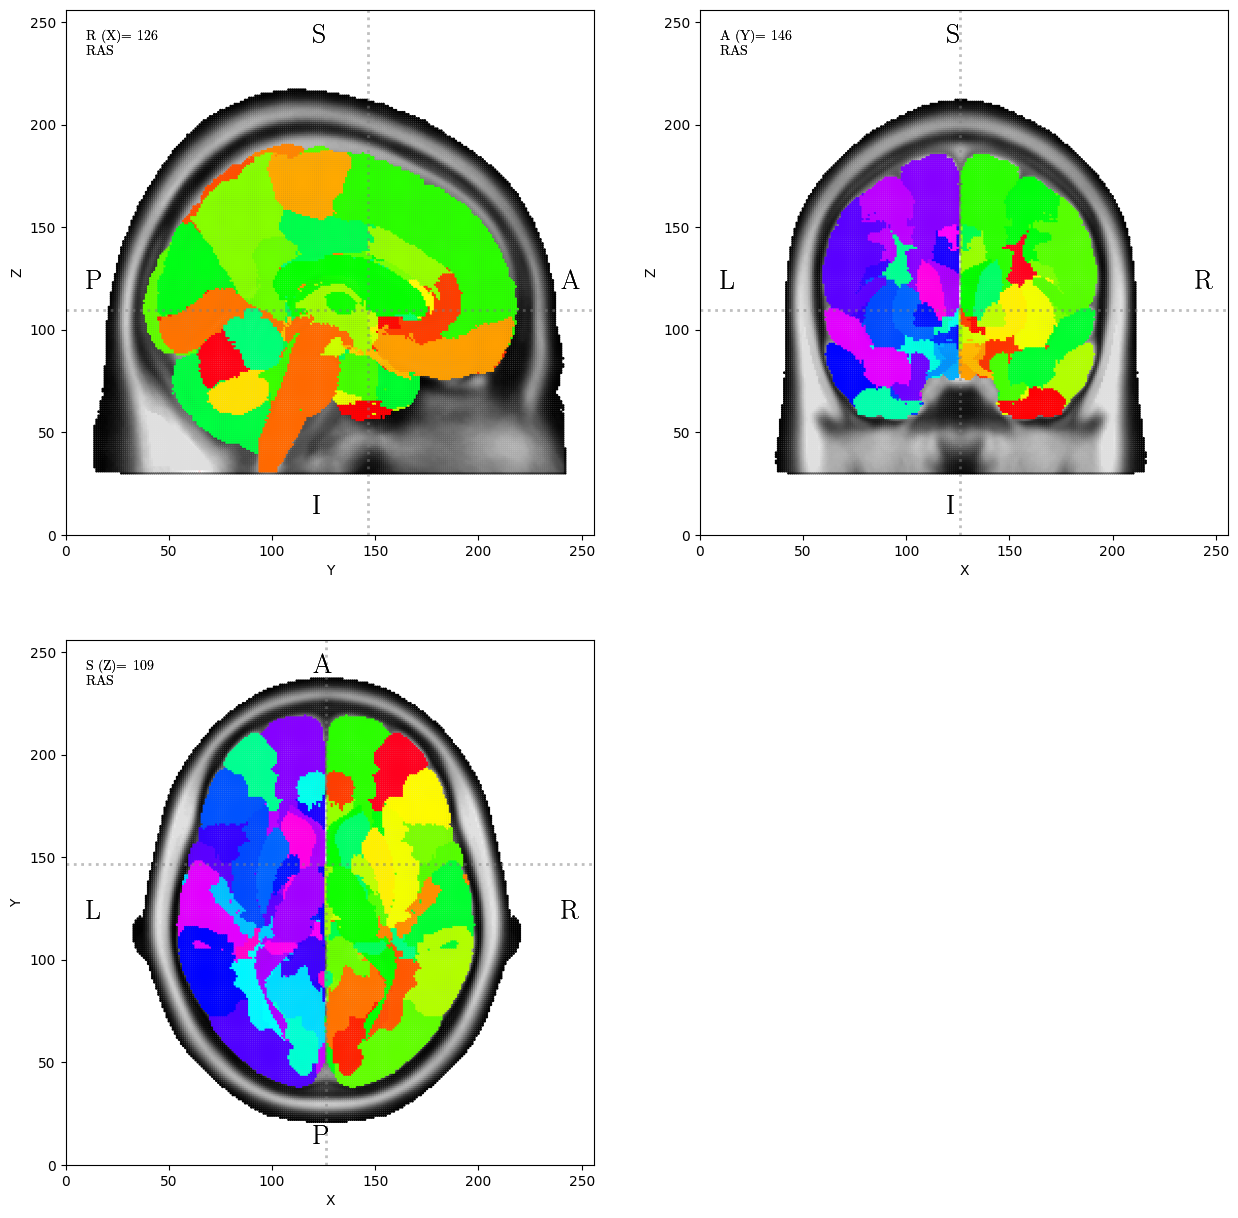

In [14]:
t1_volume, t1_affine = get_volume_ras(f"{CEREBRA_DATA_ICBM152_DIR}/mri/T1.mgz")

from cerebra_atlas_python.plotting import orthoview

fig, axs = orthoview(t1_volume, t1_affine, cmap_name="gray", plot_affine=True)
orthoview(cerebra_volume, cerebra_affine,fig=fig, axs=axs)

#### Create info (head size)

In [11]:
if op.exists(INFO_PATH):
    logging.info("BEM surfaces for subject %s already exist, skipping make_watershed_bem", NEW_SUBJECT_NAME)
else:
    from cerebra_atlas_python.utils import get_standard_montage
    logging.info("Creating info file for %s", NEW_SUBJECT_NAME)
    montage = get_standard_montage(electrode_names,kind=MONTAGE_KIND,head_size=MONTAGE_HEAD_SIZE)
    kept_ch_names = montage.ch_names
    info = mne.create_info(kept_ch_names, 5000, ch_types='eeg', verbose=False)
    info.set_montage(montage)
    info.save(INFO_PATH)


NameError: name 'INFO_PATH' is not defined

#### Manually align fiducials
Produces 

subjects/icbm152/bem/icbm152-fiducials.fif 
and
head_mri_t.fif

In [ ]:
# Save fiducials to $bem_dir/icbm152-fiducials.fif
# Save fiducials to $./head_mri_t.fif
if not op.exists(FIDUCIALS_PATH) or not op.exists(HEAD_MRI_T_PATH):
    import mne
    mne.gui.coregistration()
else:
    
    logging.info("Fiducials and head to mri transform already exists %s and %s", FIDUCIALS_PATH, HEAD_MRI_T_PATH)

 [INFO] 2023-12-13 15:53:53.849 1426419388 - <module>: Fiducials and head to mri transform already exists ../cerebra_atlas_python/cerebra_data/subjects/icbm152/bem/icbm152-fiducials.fif and ../cerebra_atlas_python/cerebra_data/subjects/icbm152/head_mri_t.fif


In [ ]:
mni_average = MNIAverage()
mni_average.head_mri_t

 [DEBUG] 2023-12-13 15:56:24.256 config - __init__: Value for variable cerebra_data_path not provided in config.ini[MNIAverage]. Defaulting to cerebra_data_path=/home/carlos/Carlos/cerebra_atlas_python/cerebra_atlas_python/cerebra_data
 [INFO] 2023-12-13 15:56:24.256 mni_average - _set_bem: Loading boundary element model from disk | MNIAverage_bem_0.33_0.0042_0.33_ico_4
 [DEBUG] 2023-12-13 15:56:24.339 mni_average - _set_fiducials: Fiducials coordinate frame: 5 (FIFFV_COORD_MRI)


<Transform | head->MRI (surface RAS)>
[[ 0.99998409  0.00051499 -0.00561859 -0.00032736]
 [-0.00093964  0.99711949 -0.07584107 -0.00204062]
 [ 0.00556335  0.07584514  0.99710411 -0.05805472]
 [ 0.          0.          0.          1.        ]]

In [ ]:
mne.dig_mri_distances(mni_average.info, mni_average.head_mri_t, mni_average.subject_name).sum()
mne.viz.plot_alignment(bem=mni_average.bem, mri_fiducials=mni_average.fiducials, trans=mni_average.head_mri_t, show_axes=True,dig=True, info = mni_average.info)

 [DEBUG] 2023-12-13 15:56:35.813 __init__ - _load_stylesheet: Reading QSS file in: :qdarkstyle/dark/darkstyle.qss
 [INFO] 2023-12-13 15:56:35.818 __init__ - _load_stylesheet: QSS file successfully loaded.
 [DEBUG] 2023-12-13 15:56:35.819 __init__ - _load_stylesheet: Checking patches for being applied.
 [INFO] 2023-12-13 15:56:35.820 __init__ - _apply_version_patches: Found version patches to be applied.
 [INFO] 2023-12-13 15:56:35.821 __init__ - _apply_application_patches: Found application patches to be applied.


# CerebrA 


#### Process labels

In [ ]:
label_details_path = op.join(CEREBRA_DIR, "CerebrA_LabelDetails.csv")
processed_label_details = get_label_details(label_details_path)
processed_label_details.to_csv(LABEL_DETAILS_PATH)
processed_label_details

,Mindboggle ID,Label Name,CerebrA ID,hemisphere,cortical,color
0,0.0,Empty,0,NaN,NaN,#000000
1,2027.0,Rostral Middle Frontal,1,Right,True,#ff001e
2,631.0,Vermal lobules VI-VII,2,Right,False,#ff0013
3,2009.0,Inferior temporal,3,Right,True,#ff0003
4,58.0,Accumbens Area,4,Right,False,#ff0700
...,...,...,...,...,...,...
99,53.0,Hippocampus,99,Left,False,#ff00f0
100,50.0,Caudate,100,Left,False,#ff00e5
101,630.0,Vermal lobules I-V,101,Left,False,#ff00d4
102,1031.0,Supramarginal,102,Left,True,#ff00ca


#### Process volume

 [INFO] 2023-12-08 00:47:07.490 utils - inspect_img: img.shape= (193, 229, 193)
 [INFO] 2023-12-08 00:47:07.491 utils - inspect_img: Coordinate frame: RAS
 [INFO] 2023-12-08 00:47:07.491 utils - inspect_img: 
[[   1.    0.    0.  -96.]
 [   0.    1.    0. -132.]
 [   0.    0.    1.  -78.]
 [   0.    0.    0.    1.]]


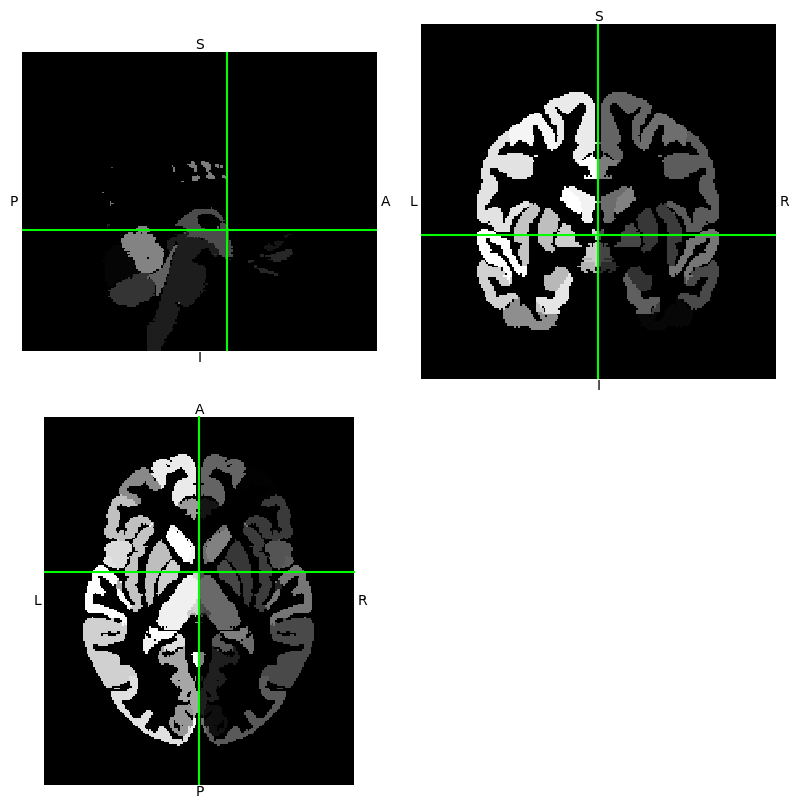

In [ ]:
inspect_img(f"{CEREBRA_DIR}/CerebrA.mgz")
pass

 [INFO] 2023-12-08 00:42:32.132 utils - inspect_img: img.shape= (256, 256, 256)
 [INFO] 2023-12-08 00:42:32.133 utils - inspect_img: Coordinate frame: LIA
 [INFO] 2023-12-08 00:42:32.134 utils - inspect_img: 
[[  -1.     0.     0.   128.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]


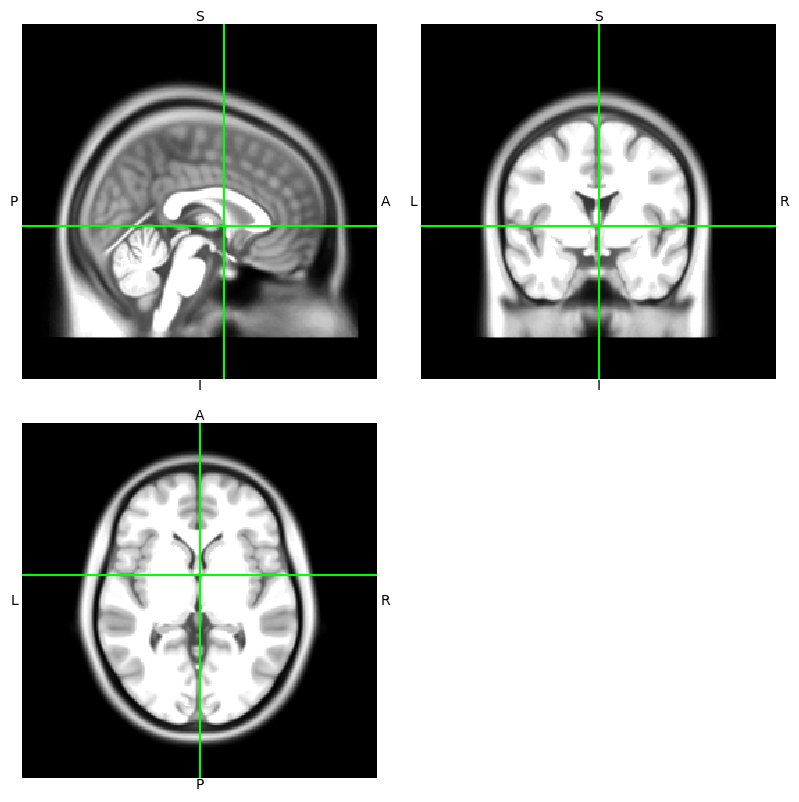

In [ ]:
inspect_img(f"{CEREBRA_DATA_SUBJECT_DIR}/mri/T1.mgz")
pass

 [INFO] 2023-12-08 00:42:32.787 utils - inspect_img: img.shape= (256, 256, 256)
 [INFO] 2023-12-08 00:42:32.788 utils - inspect_img: Coordinate frame: LIA
 [INFO] 2023-12-08 00:42:32.788 utils - inspect_img: 
[[  -1.     0.     0.   128.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]


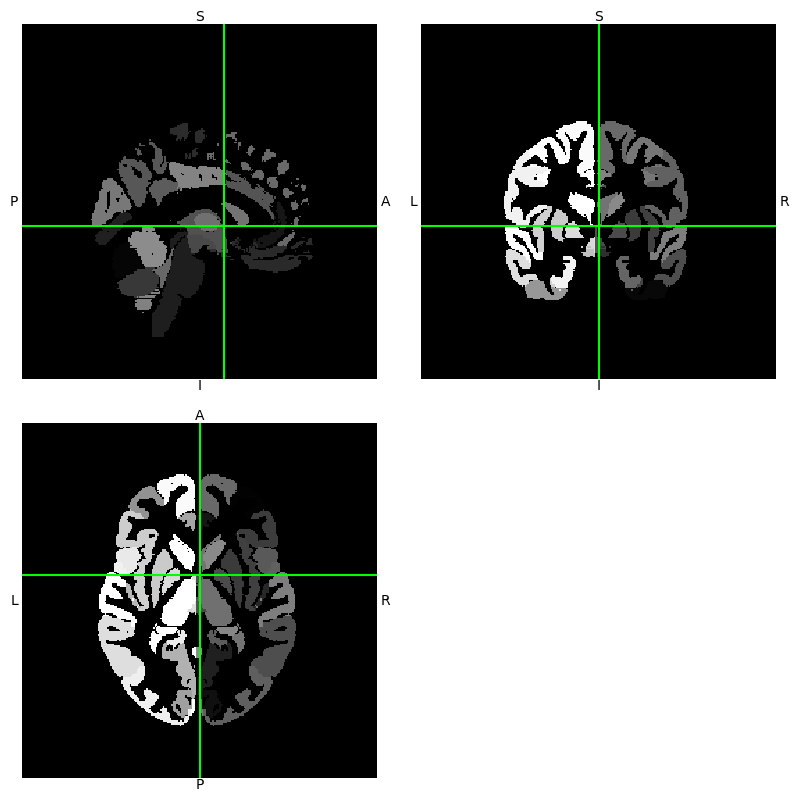

In [ ]:
inspect_img(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")
pass

 [INFO] 2023-12-08 00:42:33.55 utils - inspect_img: img.shape= (256, 256, 256)
 [INFO] 2023-12-08 00:42:33.56 utils - inspect_img: Coordinate frame: LIA
 [INFO] 2023-12-08 00:42:33.57 utils - inspect_img: 
[[  -1.     0.     0.   128.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]


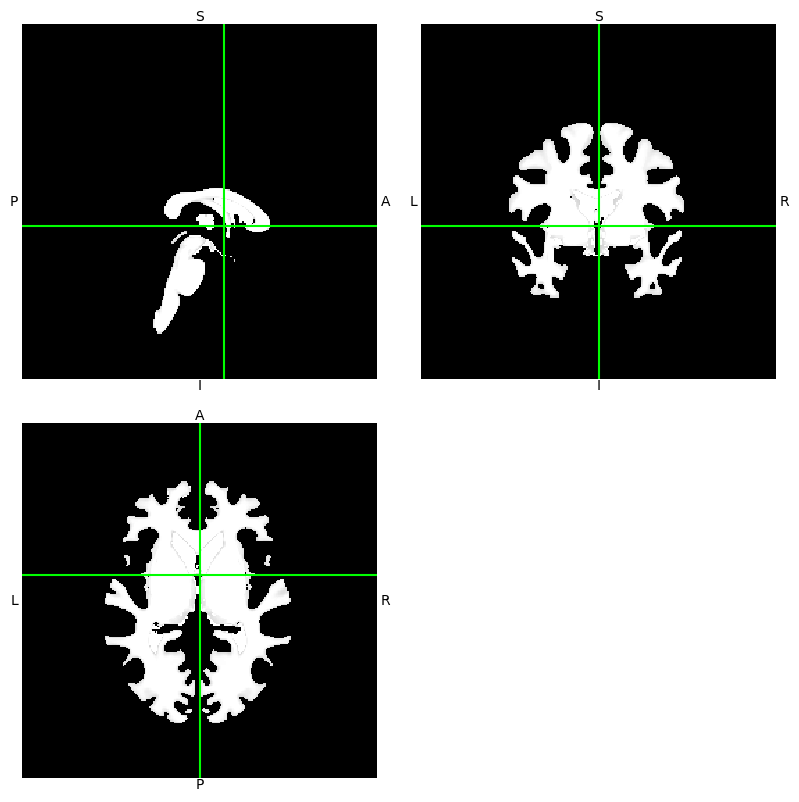

In [ ]:
inspect_img(f"{CEREBRA_DATA_SUBJECT_DIR}/mri/wm.mgz")
pass

In [ ]:
# TODO: get transforms another way?
vol_src_space_transforms = mne.setup_volume_source_space(
    subject=NEW_SUBJECT_NAME
) 
# vol_src_space_transforms.save(VOL_SOURCE_SPACE_TRANSFORMS_PATH)
mri_ras_t = vol_src_space_transforms[0]["mri_ras_t"]
mne.write_trans(MRI_RAS_T_PATH,mri_ras_t)